In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler

# Import the data and show the first few rows
yogurt = pd.read_csv('homeworks/hw3/yogurt_data.csv')
print(yogurt.head()) 
print(yogurt.describe())

   id  y1  y2  y3  y4  f1  f2  f3  f4     p1     p2     p3     p4
0   1   0   0   0   1   0   0   0   0  0.108  0.081  0.061  0.079
1   2   0   1   0   0   0   0   0   0  0.108  0.098  0.064  0.075
2   3   0   1   0   0   0   0   0   0  0.108  0.098  0.061  0.086
3   4   0   1   0   0   0   0   0   0  0.108  0.098  0.061  0.086
4   5   0   1   0   0   0   0   0   0  0.125  0.098  0.049  0.079
              id           y1           y2           y3           y4  \
count  2430.0000  2430.000000  2430.000000  2430.000000  2430.000000   
mean   1215.5000     0.341975     0.401235     0.029218     0.227572   
std     701.6249     0.474469     0.490249     0.168452     0.419351   
min       1.0000     0.000000     0.000000     0.000000     0.000000   
25%     608.2500     0.000000     0.000000     0.000000     0.000000   
50%    1215.5000     0.000000     0.000000     0.000000     0.000000   
75%    1822.7500     1.000000     1.000000     0.000000     0.000000   
max    2430.0000     1.00000

In [ ]:
# Melt the product choices, feature status, and prices in one step
long_yogurt = pd.wide_to_long(yogurt, stubnames=['y', 'f', 'p'], i='id', j='product', sep='', suffix='\\d+')

# Reset index to get a tidy dataframe
long_yogurt = long_yogurt.reset_index()

# Rename the columns to match the desired format
long_yogurt = long_yogurt.rename(columns={'y': 'choice', 'f': 'featured', 'p': 'price'})

# Create dummy variables for the first three products
long_yogurt['yogurt_1'] = (long_yogurt['product'] == 1).astype(int)
long_yogurt['yogurt_2'] = (long_yogurt['product'] == 2).astype(int)
long_yogurt['yogurt_3'] = (long_yogurt['product'] == 3).astype(int)

# Sort by 'id'
long_yogurt = long_yogurt.sort_values(by=['id', 'product']).reset_index(drop=True)

# Drop 'product' column 
long_yogurt = long_yogurt.drop(columns=['product'])
long_yogurt

,id,choice,featured,price,yogurt_1,yogurt_2,yogurt_3
0,1,0,0,0.108,1,0,0
1,1,0,0,0.081,0,1,0
2,1,0,0,0.061,0,0,1
3,1,1,0,0.079,0,0,0
4,2,0,0,0.108,1,0,0
...,...,...,...,...,...,...,...
9715,2429,1,0,0.086,0,0,0
9716,2430,0,0,0.108,1,0,0
9717,2430,0,0,0.086,0,1,0
9718,2430,0,0,0.043,0,0,1


In [ ]:
import numpy as np 


In [ ]:
# Define the variables
X = long_yogurt[['yogurt_1', 'yogurt_2', 'yogurt_3','featured', 'price']].values
y = long_yogurt['choice'].values

# Ensure the dependent variable is binary
y = (y == 1).astype(int)

# Add intercept
X = np.hstack((np.ones((X.shape[0], 1)), X))

# Initialize beta
initial_beta = np.zeros(X.shape[1])

# Define the log-likelihood function
def log_likelihood(beta, X, y):
    Xbeta = np.dot(X, beta)
    exp_Xbeta = np.exp(Xbeta)
    log_likelihood = np.sum(y * Xbeta - np.log(1 + exp_Xbeta))
    return -log_likelihood

# Define the function to calculate the gradient
def gradient(beta, X, y):
    Xbeta = np.dot(X, beta)
    exp_Xbeta = np.exp(Xbeta)
    prob = exp_Xbeta / (1 + exp_Xbeta)
    gradient = np.dot(X.T, y - prob)
    return -gradient

# Optimize the log-likelihood function
result = minimize(log_likelihood, initial_beta, args=(X, y), jac=gradient, method='BFGS')
beta_hat = result.x

beta_hat

array([  1.28298667,   1.41787094,   0.90126398,  -3.14053695,
         0.47140946, -31.97609653])

In [ ]:
import statsmodels.api as sm


In [ ]:
# Combine the feature columns into a single matrix X
X_mn = long_yogurt[['yogurt_1', 'yogurt_2', 'yogurt_3', 'featured', 'price']]

# The dependent variable is the product choice
y_mn = long_yogurt['choice']

# Fit the multinomial logit model using statsmodels
X_mn = sm.add_constant(X_mn)  # Add a constant term to the predictors
model = sm.MNLogit(y_mn, X_mn)
result_mn = model.fit()

# Display the summary of the model
result_mn.summary()

Optimization terminated successfully.
         Current function value: 0.477971
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 choice   No. Observations:                 9720
Model:                        MNLogit   Df Residuals:                     9714
Method:                           MLE   Df Model:                            5
Date:                Tue, 14 May 2024   Pseudo R-squ.:                  0.1500
Time:                        16:19:45   Log-Likelihood:                -4645.9
converged:                       True   LL-Null:                       -5465.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
  choice=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2830      0.173      7.420      0.000       0.944       1.622
yogurt_1       1.4179      0.089     16.008      0.000       1.244       1.591
yogurt_2       0.9013      0.065     13.909      0.000       0.774       1.028
yogurt_3      -3.1405      0.142    -22.072      0.000      -3.419      -2.862
featured       0.4714      0.119      3.959      0.000       0.238       0.705
price        -31.9761      2.089    -15.305      0.000     -36.071     -27.881
==============================================================================
"""

In [ ]:
# Predict choice probabilities
predicted_probs = result_mn.predict(X_mn)
predicted_probs

,0,1
0,0.679736,0.320264
1,0.600084,0.399916
2,0.978291,0.021709
3,0.776108,0.223892
4,0.679736,0.320264
...,...,...
9715,0.812595,0.187405
9716,0.679736,0.320264
9717,0.637769,0.362231
9718,0.962040,0.037960


In [ ]:
# Calculate current market shares
current_market_shares = predicted_probs.mean(axis=0)
print("Current Market Shares:")
print(current_market_shares)

Current Market Shares:
0    0.75
1    0.25
dtype: float64


In [ ]:
# Increase the price of yogurt 1 by $0.10
X_mn_new = X_mn.copy()
X_mn_new.loc[long_yogurt['yogurt_1'] == 1, 'price'] += 0.10

# Predict new choice probabilities with increased price for yogurt 1
predicted_probs_new = result_mn.predict(X_mn_new)

# Calculate new market shares
new_market_shares = predicted_probs_new.mean(axis=0)
print("New Market Shares after $0.10 price increase for Yogurt 1:")
print(new_market_shares)

New Market Shares after $0.10 price increase for Yogurt 1:
0    0.828349
1    0.171651
dtype: float64


In [ ]:
# Check if the market share of yogurt 1 decreased
market_share_decrease = current_market_shares[1] - new_market_shares[1]
print("Change in Market Share for Yogurt 1:")
print(market_share_decrease)

Change in Market Share for Yogurt 1:
0.07834917598912244


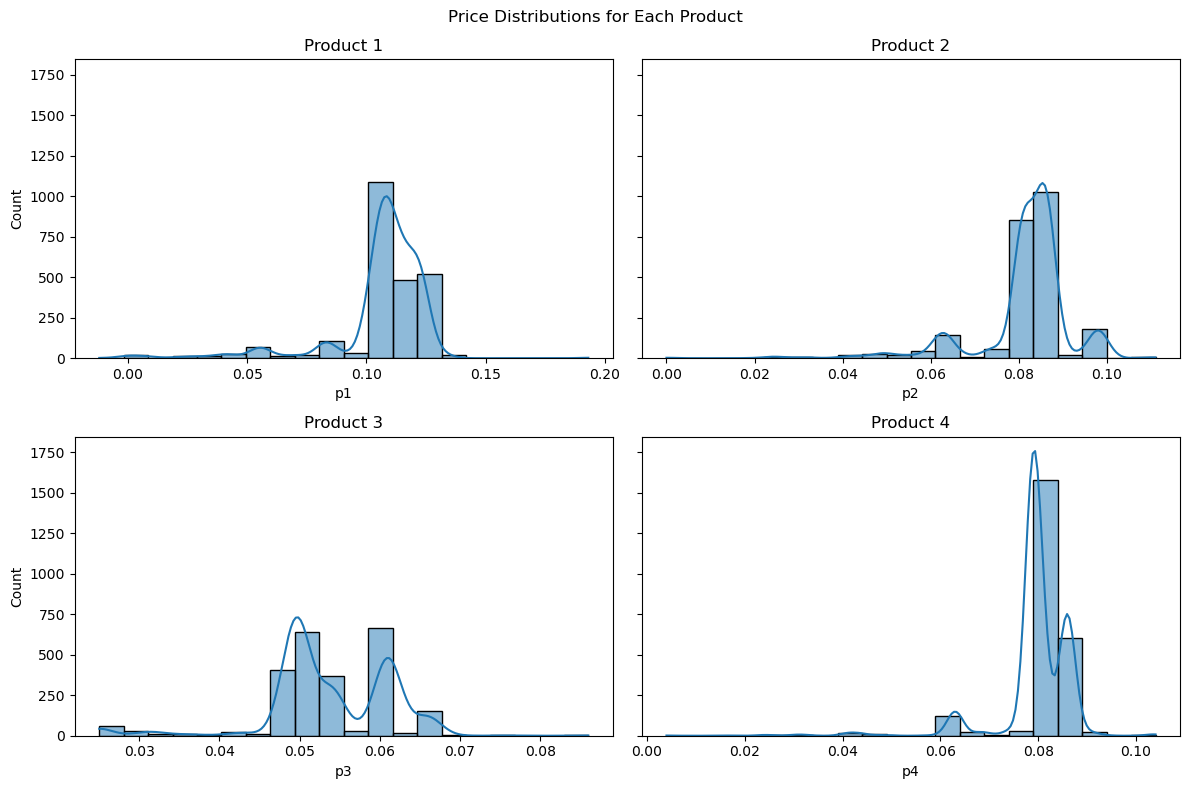

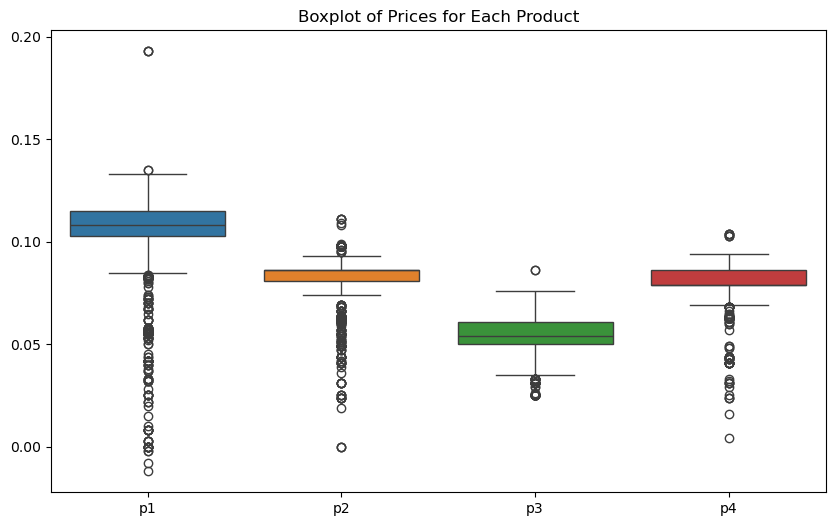

In [ ]:
price_columns = ['p1', 'p2', 'p3', 'p4']

# Plot histograms for prices of each product
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
fig.suptitle('Price Distributions for Each Product')

sns.histplot(yogurt['p1'], bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Product 1')

sns.histplot(yogurt['p2'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Product 2')

sns.histplot(yogurt['p3'], bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Product 3')

sns.histplot(yogurt['p4'], bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Product 4')

plt.tight_layout()
plt.show()

# Plot boxplots for prices of each product
plt.figure(figsize=(10, 6))
sns.boxplot(data=yogurt[price_columns])
plt.title('Boxplot of Prices for Each Product')
plt.show()